<a href="https://colab.research.google.com/github/sourit123/Sourit-Khamaru/blob/main/FD_Pfizer_Inc_USD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance


In [ ]:
!pip install fredapi

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import jarque_bera, kstest
from fredapi import Fred
import datetime as dt

In [ ]:
ticker_symbol = 'PFE'
data = yf.download(ticker_symbol, period="max")
data.to_csv(f"{ticker_symbol}_historical_data.csv")

[*********************100%***********************]  1 of 1 completed


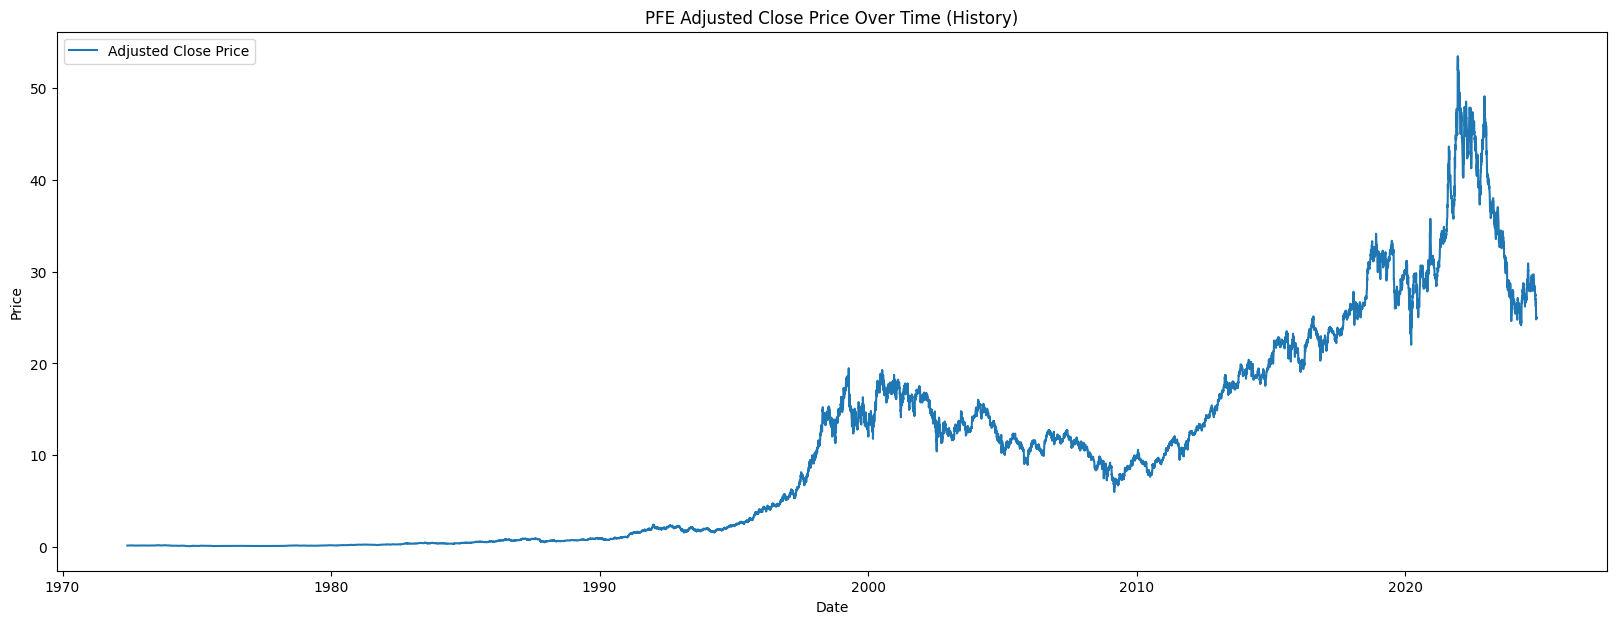

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(data['Adj Close'], label='Adjusted Close Price')
plt.title(f'{ticker_symbol} Adjusted Close Price Over Time (History)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

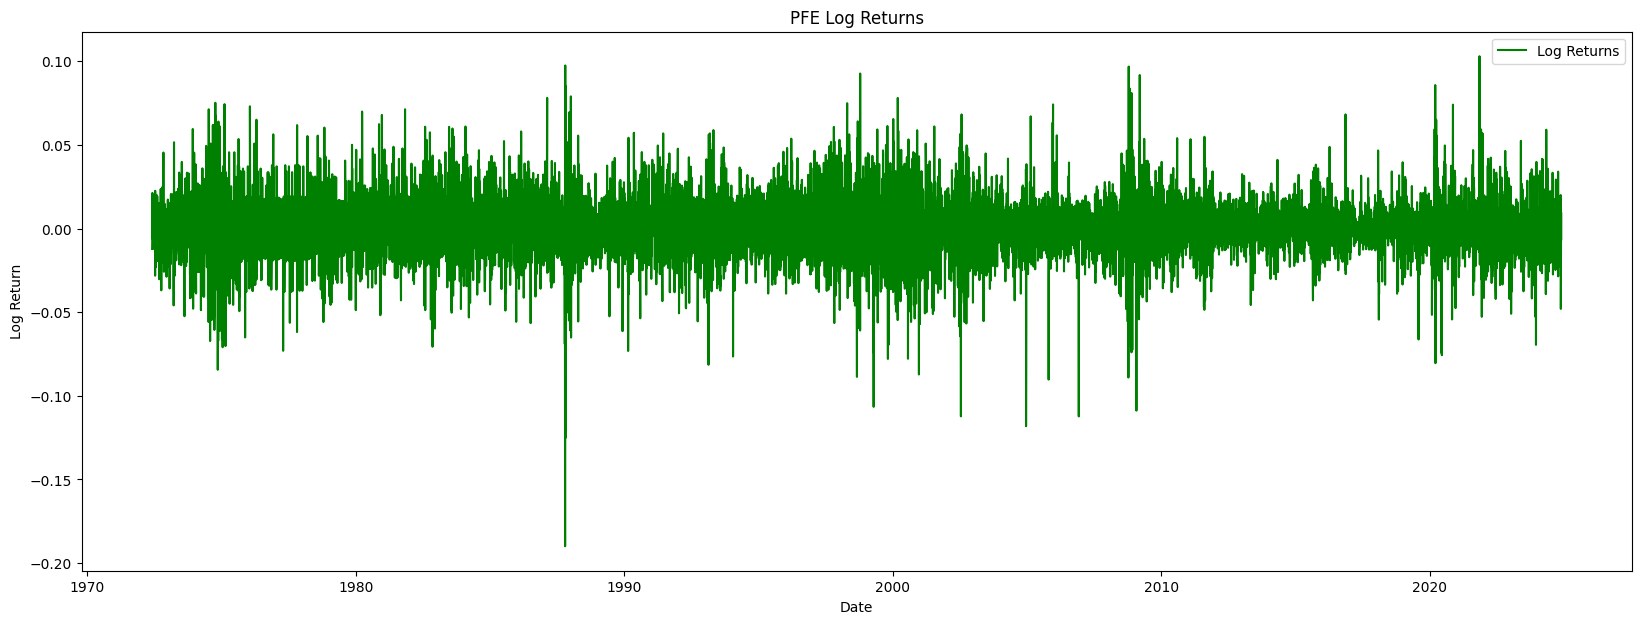

In [ ]:
data['Log Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
plt.figure(figsize=(20, 7))
plt.plot(data['Log Returns'], label='Log Returns', color='green')
plt.title(f'{ticker_symbol} Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()

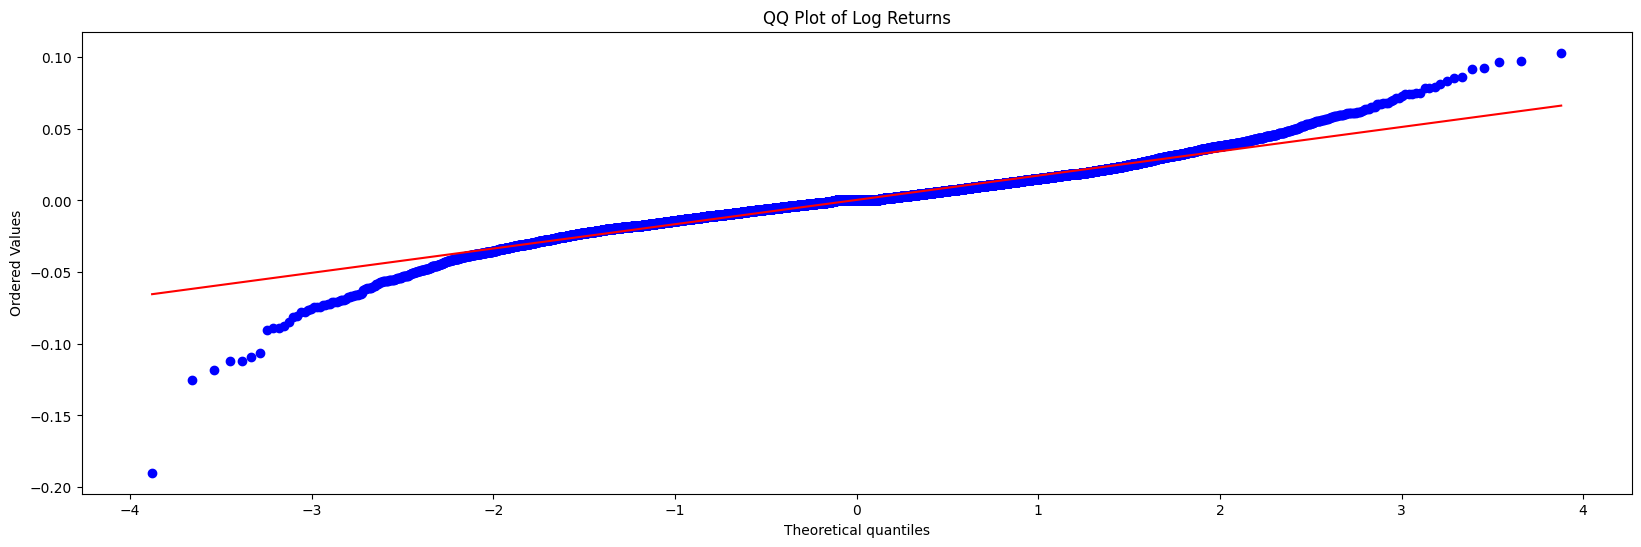

In [ ]:
plt.figure(figsize=(20, 6))
stats.probplot(data['Log Returns'].dropna(), dist="norm", plot=plt)
plt.title('QQ Plot of Log Returns')
plt.show()

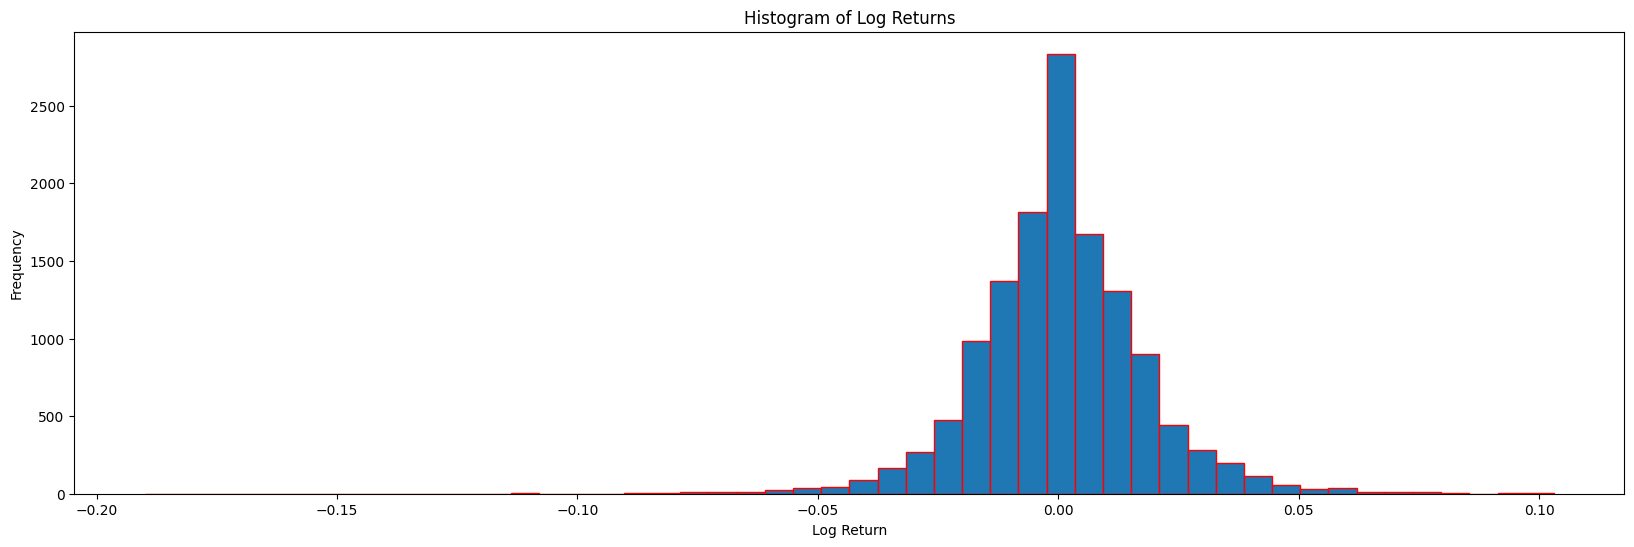

In [ ]:
plt.figure(figsize=(20, 6))
plt.hist(data['Log Returns'].dropna(), bins=50, edgecolor='Red')
plt.title('Histogram of Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.show()

In [ ]:
jb_stat, jb_pvalue = jarque_bera(data['Log Returns'].dropna())
print(f"Jarque-Bera test statistic: {jb_stat}, p-value: {jb_pvalue}")

Jarque-Bera test statistic: 9896.019485354669, p-value: 0.0


In [ ]:
ks_stat, ks_pvalue = kstest(data['Log Returns'].dropna(), 'norm')
print(f"Kolmogorov-Smirnov test statistic: {ks_stat}, p-value: {ks_pvalue}")

Kolmogorov-Smirnov test statistic: 0.47299179472177183, p-value: 0.0


In [ ]:
volatility = data['Log Returns'].std() * np.sqrt(252)
print(f"Annualized Historical Volatility: {volatility:.2%}")


Annualized Historical Volatility: 27.44%


In [ ]:
fred = Fred(api_key='661a87aa61c5a033e7db39a3e342af37')
series_id = 'DGS3MO'
end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(days=7)
risk_free_rate_data = fred.get_series(series_id, start_date, end_date)
latest_risk_free_rate = risk_free_rate_data.iloc[-1] if not risk_free_rate_data.empty else None
if latest_risk_free_rate is not None:
    print(f"Latest 3-Month Treasury Rate (Risk-Free Rate): {latest_risk_free_rate:.2f}%")
else:
    print("No data available for the 3-month Treasury rate.")

Latest 3-Month Treasury Rate (Risk-Free Rate): 4.62%


In [ ]:
# Replace 'your_fred_api_key' with your actual FRED API key
fred_api_key = '661a87aa61c5a033e7db39a3e342af37'
fred = Fred(api_key=fred_api_key)

# Fetch 3-Month Treasury Rate
risk_free_series_id = 'DGS3MO'  # 3-Month Treasury Rate
end_date = dt.datetime.today().strftime('%Y-%m-%d')
start_date = (dt.datetime.today() - dt.timedelta(days=365)).strftime('%Y-%m-%d')

risk_free_data = fred.get_series(risk_free_series_id, start_date, end_date)
risk_free_rate = risk_free_data.iloc[-1] / 100  # Convert to decimal
print(f"Risk-Free Rate (3-Month Treasury Rate): {risk_free_rate:.4%}")


Risk-Free Rate (3-Month Treasury Rate): 4.6200%


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test for independence of log-returns
lb_test = acorr_ljungbox(data['Log Returns'].dropna(), lags=[10], return_df=True)
print("Ljung-Box Test Results:")
print(lb_test)


Ljung-Box Test Results:
      lb_stat     lb_pvalue
10  47.130767  8.939358e-07


In [ ]:
from scipy.stats import norm
import numpy as np

# Black-Scholes Formula
def black_scholes(S, K, T, r, sigma, option_type="call"):
    # Ensure S is a single numeric value by taking the first element if it's a Series
    S = S.iloc[0] if isinstance(S, pd.Series) else S
    d1 = (np.log(S / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")
    return price

# Parameters for the options
S = data['Adj Close'].iloc[-1]  # Current stock price
K_call = S * 0.9  # Strike price for ITM Call (90% of current price)
K_put = S * 1.1   # Strike price for ITM Put (110% of current price)
T = (dt.datetime(2024, 11, 15) - dt.datetime.today()).days / 365  # Time to maturity
sigma = data['Log Returns'].std() * np.sqrt(252)  # Historical volatility

# Calculate Black-Scholes Prices
call_price = black_scholes(S, K_call, T, risk_free_rate, sigma, option_type="call")
put_price = black_scholes(S, K_put, T, risk_free_rate, sigma, option_type="put")

# Convert call_price and put_price to float before printing
print(f"ITM European Call Option Price: {float(call_price):.2f}")
print(f"ITM European Put Option Price: {float(put_price):.2f}")

ITM European Call Option Price: nan
ITM European Put Option Price: nan


<ipython-input-139-9e93811638ff>:8: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
<ipython-input-139-9e93811638ff>:9: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
<ipython-input-139-9e93811638ff>:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"ITM European Call Option Price: {float(call_price):.2f}")
<ipython-input-139-9e93811638ff>:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(f"ITM European Put Option Price: {float(put_price):.2f}")


In [ ]:
def crr_binomial_tree(S, K, T, r, sigma, steps, option_type="call"):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Generate terminal stock prices
    prices = np.zeros(steps + 1)
    for i in range(steps + 1):
        prices[i] = S * (u ** i) * (d ** (steps - i))

    # Terminal payoff
    # Convert K to a scalar value to avoid index alignment issues
    K = K.iloc[0] if isinstance(K, pd.Series) else K
    payoffs = np.maximum(0, prices - K) if option_type == "call" else np.maximum(0, K - prices)

    # Backward induction
    for step in range(steps - 1, -1, -1):
        payoffs = (p * payoffs[:-1] + (1 - p) * payoffs[1:]) * np.exp(-r * dt)

    return payoffs[0]

# Parameters for CRR
steps = 100  # Number of binomial steps

call_price_crr = crr_binomial_tree(S, K_call, T, risk_free_rate, sigma, steps, option_type="call")
put_price_crr = crr_binomial_tree(S, K_put, T, risk_free_rate, sigma, steps, option_type="put")

print(f"ITM European Call Option Price (CRR Model): {call_price_crr:.2f}")
print(f"ITM European Put Option Price (CRR Model): {put_price_crr:.2f}")


ITM European Call Option Price (CRR Model): nan
ITM European Put Option Price (CRR Model): nan


<ipython-input-141-667c58cf6552>:3: RuntimeWarning: invalid value encountered in sqrt
  u = np.exp(sigma * np.sqrt(dt))
<ipython-input-141-667c58cf6552>:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prices[i] = S * (u ** i) * (d ** (steps - i))


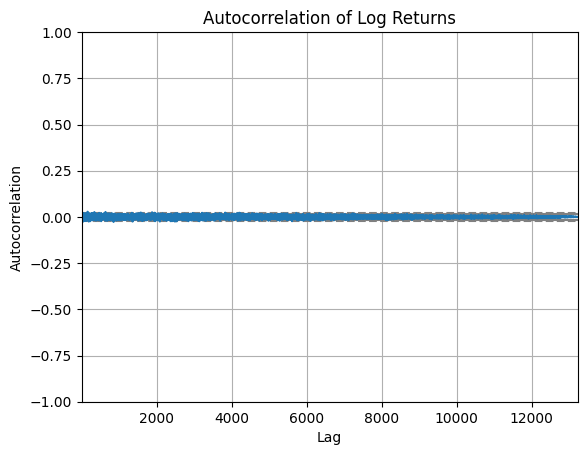

In [ ]:
pd.plotting.autocorrelation_plot(data['Log Returns'].dropna())
plt.title('Autocorrelation of Log Returns')
plt.show()


In [ ]:
risk_free_rate = 0.05  # Example: 5%


In [ ]:
S = data['Adj Close'].iloc[-1]  # Current stock price
K = S * 0.9  # ITM strike price
# Convert '2024-11-15' to a Timestamp and localize to the timezone of data.index
maturity_date = pd.Timestamp('2024-11-15').tz_localize(data.index.tz)
T = (maturity_date - data.index[-1]).days / 365  # Time to maturity
sigma = volatility  # Historical volatility
r = risk_free_rate  # Risk-free rate

In [ ]:
from scipy.stats import norm

def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

call_price = black_scholes(S, K, T, r, sigma, option_type='call')
put_price = black_scholes(S, K, T, r, sigma, option_type='put')
print(f"Call Price: {call_price}, Put Price: {put_price}")


Call Price: Ticker
PFE   NaN
Name: 2024-11-20 00:00:00+00:00, dtype: float64, Put Price: Ticker
PFE   NaN
Name: 2024-11-20 00:00:00+00:00, dtype: float64


<ipython-input-146-4199edad9c57>:4: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
<ipython-input-146-4199edad9c57>:5: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
